#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET).

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion

- No significant difference between both models
- No support for early stopping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['improved_magpruning_eval3', 'improved_magpruning_eval7', 'improved_magpruning_eval8']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [4]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,momentum,network,num_classes,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc
0,0_on_perc=0.0,0.112367,30,0.106067,1,0.112367,0.112367,0.1135,2,0.0958,...,0.9,MLPHeb,10,0.000,SGD,2,False,False,0.0001,0.3
1,1_on_perc=0.005,0.160550,5,0.094450,4,0.112367,0.112367,0.1760,5,0.0716,...,0.9,MLPHeb,10,0.005,SGD,2,False,False,0.0001,0.3
2,2_on_perc=0.01,0.692383,28,0.193100,0,0.599850,0.648933,0.7023,28,0.2149,...,0.9,MLPHeb,10,0.010,SGD,2,False,False,0.0001,0.3
3,3_on_perc=0.015,0.682750,3,0.394467,0,0.523317,0.523750,0.7275,19,0.4076,...,0.9,MLPHeb,10,0.015,SGD,2,False,False,0.0001,0.3
4,4_on_perc=0.02,0.938533,35,0.580717,0,0.846358,0.833383,0.9446,34,0.6339,...,0.9,MLPHeb,10,0.020,SGD,2,False,False,0.0001,0.3


In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'epochs',
       'experiment_file_name', 'trial_time', 'mean_epoch_time', 'batch_norm',
       'data_dir', 'dataset_name', 'debug_sparse', 'debug_weights', 'device',
       'hebbian_grow', 'hebbian_prune_perc', 'hidden_sizes', 'input_size',
       'learning_rate', 'lr_gamma', 'lr_milestones', 'lr_scheduler', 'model',
       'momentum', 'network', 'num_classes', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc'],
      dtype='object')

In [7]:
df.shape

(578, 42)

In [8]:
df.iloc[1]

Experiment Name                                           1_on_perc=0.005
train_acc_max                                                     0.16055
train_acc_max_epoch                                                     5
train_acc_min                                                     0.09445
train_acc_min_epoch                                                     4
train_acc_median                                                 0.112367
train_acc_last                                                   0.112367
val_acc_max                                                         0.176
val_acc_max_epoch                                                       5
val_acc_min                                                        0.0716
val_acc_min_epoch                                                       4
val_acc_median                                                     0.1135
val_acc_last                                                       0.1135
epochs                                

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       184
DSNNWeightedMag    210
SparseModel        184
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

6

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(572, 42)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

131    11
132    18
133    10
134    18
135     9
136     9
Name: epochs, dtype: int64

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [14]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   45       0.114  0.983  0.874  0.251   181
DSNNWeightedMag                40       0.114  0.982  0.873  0.247   210
SparseModel                    44       0.114  0.977  0.802  0.287   181

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                   0       0.114  0.114  0.114  0.000    28
0.005                  18       0.114  0.546  0.195  0.111    28
0.010                  28       0.175  0.898  0.535  0.221    28
0.015                  30       0.385  0.937  0.748  0.173    28
0.020                  45       0.433  0.958  0.868  0.139    28
0.025                  52       0.722  0.966  0.915  0.071    28
0.030                  57       0.793  0.971  0.941  0.049    28
0.035                  52       0.935  0.975  0.961  0.014    28
0.040                  56       0.945  0.976  0.965  0.012    28
0.045                  61       0.951  0.977  0.968  0.010    28
0.050                  54       0.956  0.978  0.970  0.008    28
0.055                  45       0.960  0.979  0.972  0.007    28
0.060                  48       0.961  0.980  0.974  0.006    28
0.065                  49       0.965  0.980  0.975  0.006    26
0.070                  52       0.967  0.981  0.976  0.005    26
0.075                  48       0.969  0.982  0.977  0.005    26
0.080                  39       0.970  0.982  0.977  0.004    26
0.085                  41       0.970  0.982  0.978  0.004    26
0.090                  41       0.971  0.982  0.978  0.004    26
0.095                  41       0.973  0.983  0.979  0.004    26
0.100                  45       0.972  0.982  0.979  0.003    26

In [17]:
agg(['on_perc', 'model'])

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.000   DSNNMixedHeb                    0       0.114  0.114  0.114  0.000   
        DSNNWeightedMag                 0       0.114  0.114  0.114  0.000   
        SparseModel                     0       0.114  0.114  0.114  0.000   
0.005   DSNNMixedHeb                   16       0.114  0.546  0.245  0.161   
        DSNNWeightedMag                30       0.114  0.362  0.203  0.084   
        SparseModel                     5       0.114  0.183  0.134  0.029   
0.010   DSNNMixedHeb                   35       0.360  0.898  0.634  0.221   
        DSNNWeightedMag                22       0.528  0.856  0.661  0.111   
        SparseModel                    28       0.175  0.398  0.295  0.083   
0.015   DSNNMixedHeb                   27       0.819  0.937  0.878  0.050   
        DSNNWeightedMag                26       0.653  0.924  0.829  0.107   
        SparseModel                    37       0.385  0.613  0.528  0.068   
0.020   DSNNMixedHeb                   46       0.936  0.958  0.949  0.008   
        DSNNWeightedMag                29       0.929  0.952  0.942  0.007   
        SparseModel                    62       0.433  0.848  0.702  0.142   
0.025   DSNNMixedHeb                   51       0.955  0.966  0.961  0.004   
        DSNNWeightedMag                39       0.934  0.962  0.951  0.008   
        SparseModel                    66       0.722  0.923  0.828  0.068   
0.030   DSNNMixedHeb                   71       0.964  0.971  0.968  0.002   
        DSNNWeightedMag                42       0.960  0.968  0.964  0.003   
        SparseModel                    59       0.793  0.940  0.888  0.058   
0.035   DSNNMixedHeb                   48       0.969  0.975  0.972  0.002   
        DSNNWeightedMag                43       0.966  0.972  0.969  0.002   
        SparseModel                    66       0.935  0.945  0.941  0.004   
0.040   DSNNMixedHeb                   61       0.972  0.976  0.974  0.001   
        DSNNWeightedMag                53       0.969  0.975  0.972  0.002   
        SparseModel                    53       0.945  0.954  0.949  0.004   
0.045   DSNNMixedHeb                   56       0.974  0.977  0.976  0.001   
        DSNNWeightedMag                56       0.971  0.975  0.973  0.001   
        SparseModel                    72       0.951  0.956  0.954  0.002   
...                                   ...         ...    ...    ...    ...   
0.055   DSNNMixedHeb                   47       0.976  0.979  0.978  0.001   
        DSNNWeightedMag                44       0.974  0.977  0.976  0.001   
        SparseModel                    45       0.960  0.965  0.963  0.002   
0.060   DSNNMixedHeb                   51       0.976  0.980  0.979  0.001   
        DSNNWeightedMag                52       0.976  0.978  0.977  0.001   
        SparseModel                    41       0.961  0.968  0.965  0.002   
0.065   DSNNMixedHeb                   56       0.978  0.980  0.979  0.001   
        DSNNWeightedMag                43       0.976  0.979  0.978  0.001   
        SparseModel                    50       0.965  0.968  0.966  0.001   
0.070   DSNNMixedHeb                   66       0.978  0.981  0.980  0.001   
        DSNNWeightedMag                43       0.977  0.980  0.978  0.001   
        SparseModel                    48       0.967  0.970  0.968  0.001   
0.075   DSNNMixedHeb                   53       0.979  0.982  0.980  0.001   
        DSNNWeightedMag                51       0.978  0.981  0.979  0.001   
        SparseModel                    42       0.969  0.971  0.970  0.001   
0.080   DSNNMixedHeb                   36       0.980  0.982  0.981  0.001   
        DSNNWeightedMag                45       0.978  0.981  0.979  0.001   
        SparseModel                    36     

In [18]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'DSNN',
    'DSNNMixedHeb': 'SET',
    'SparseModel': 'Static',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

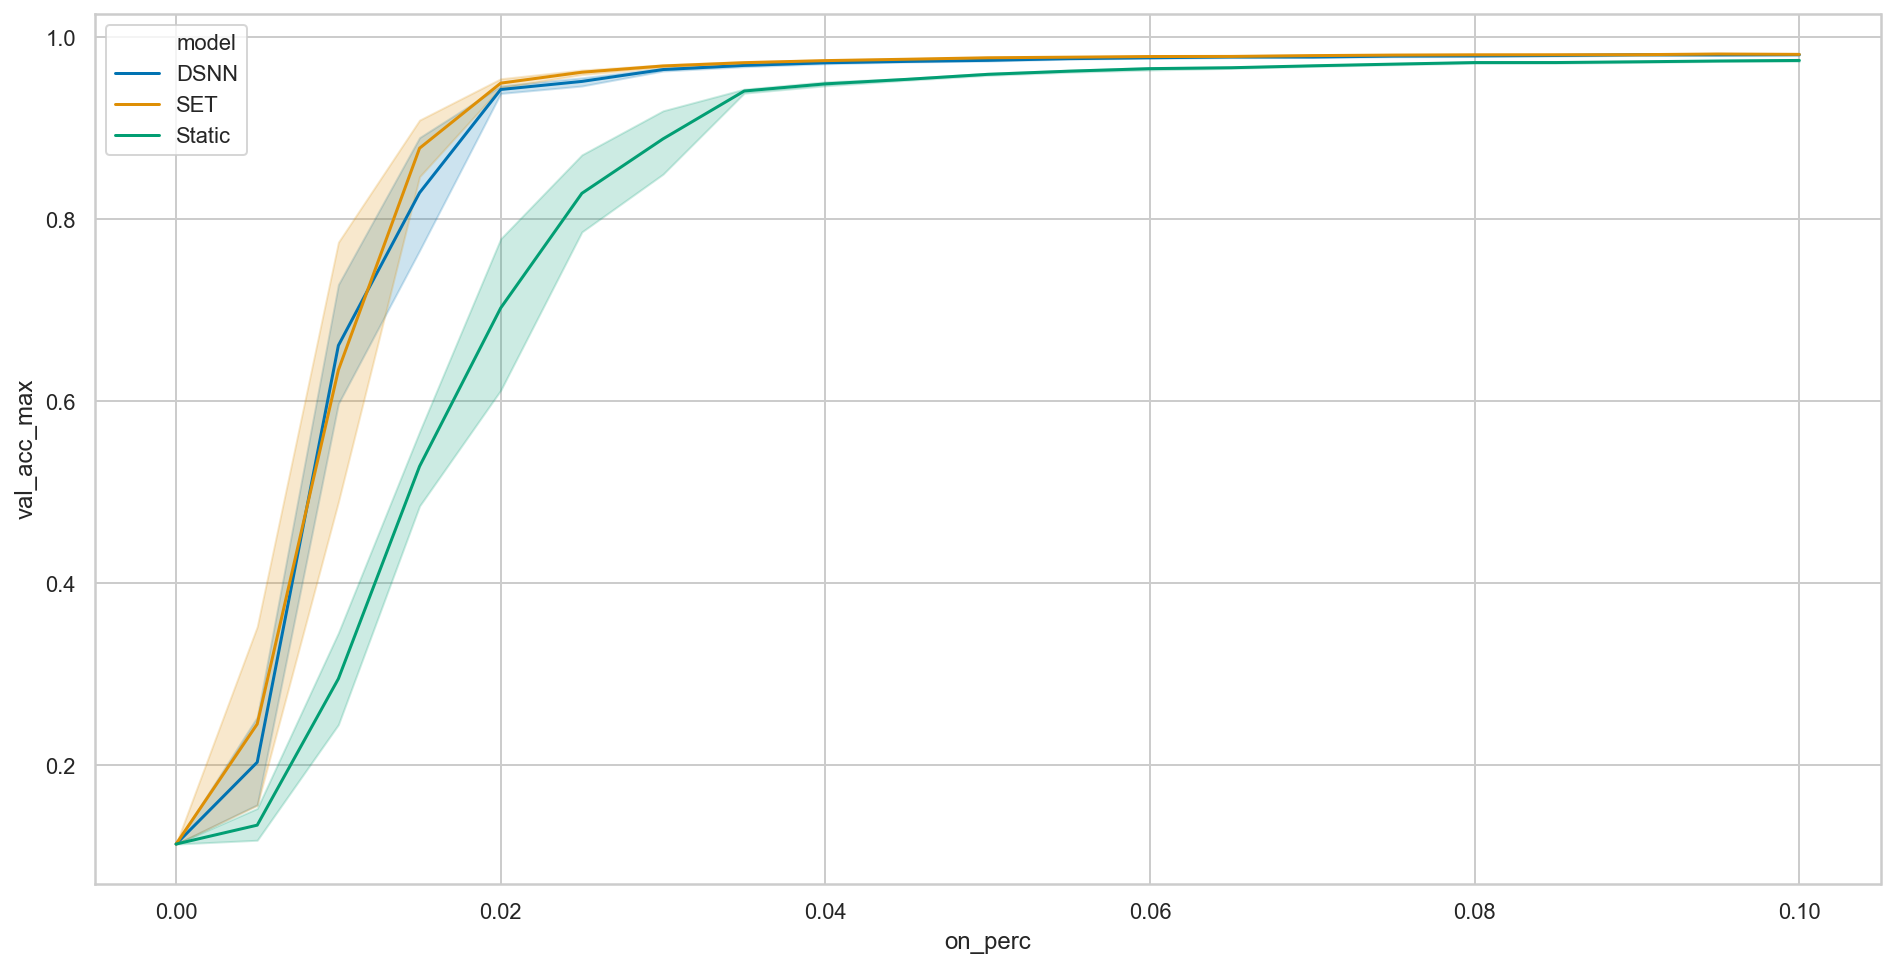

In [19]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')

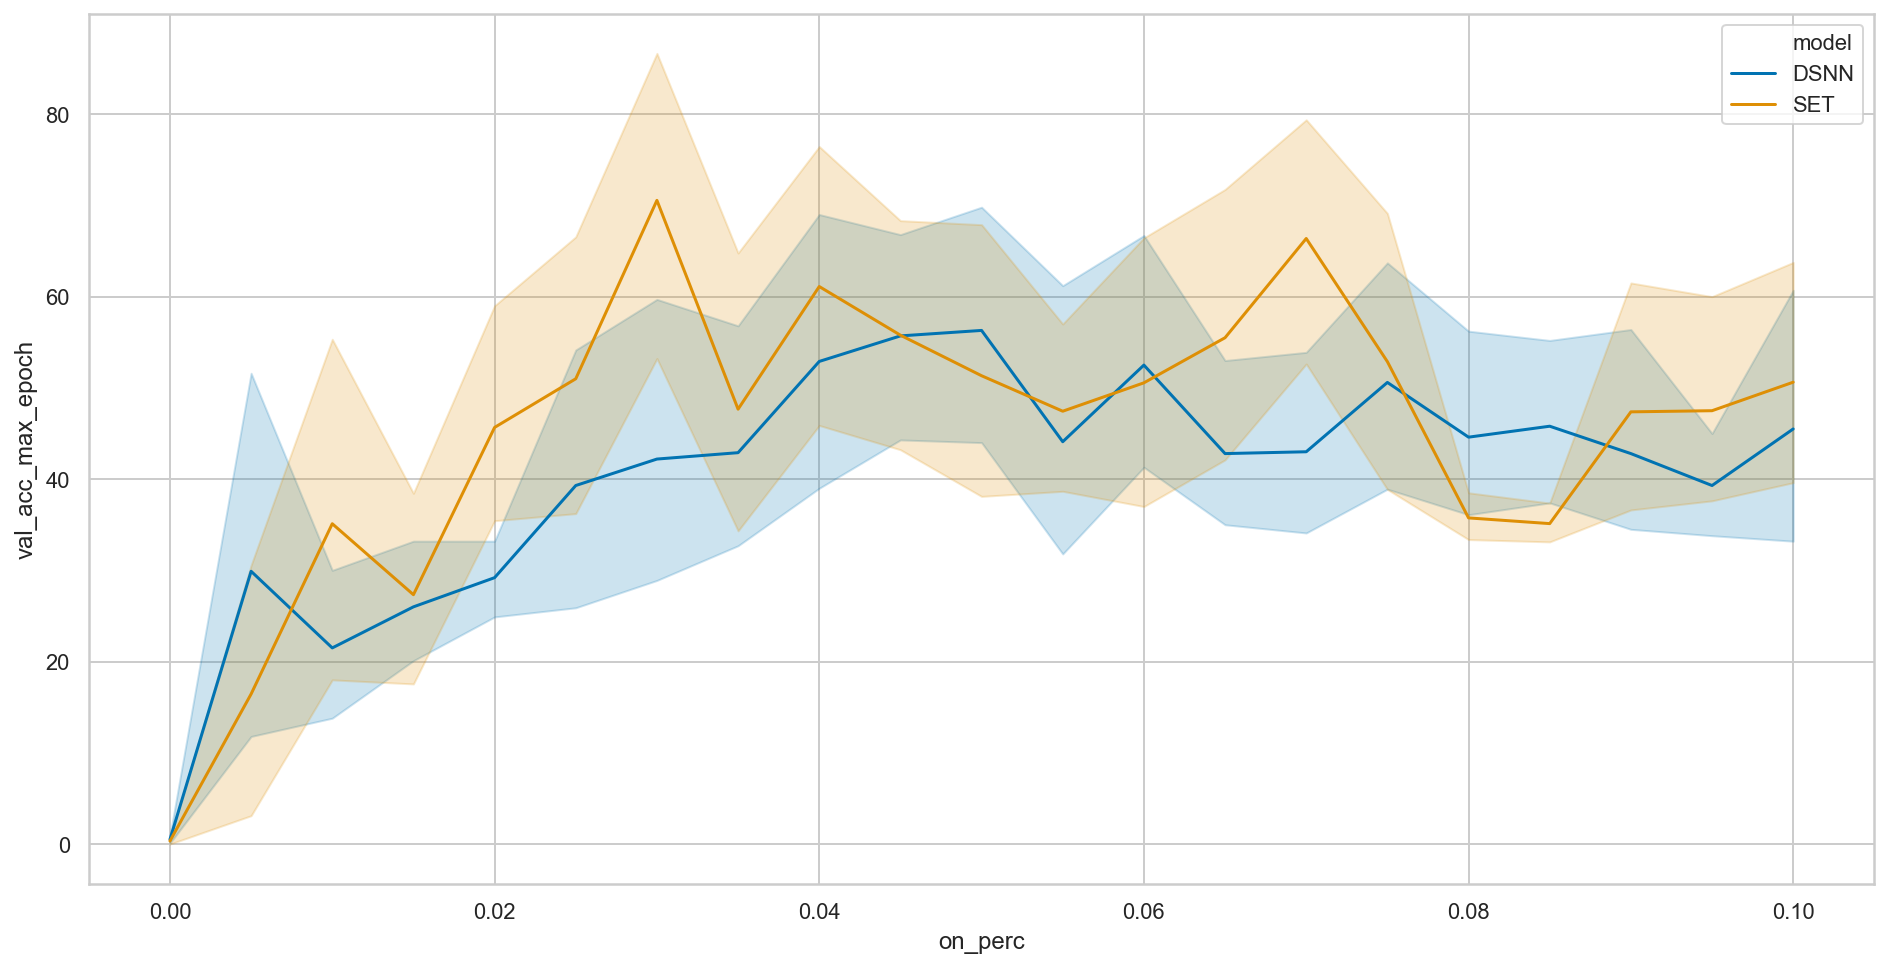

In [20]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='on_perc', y='val_acc_max_epoch', hue='model')

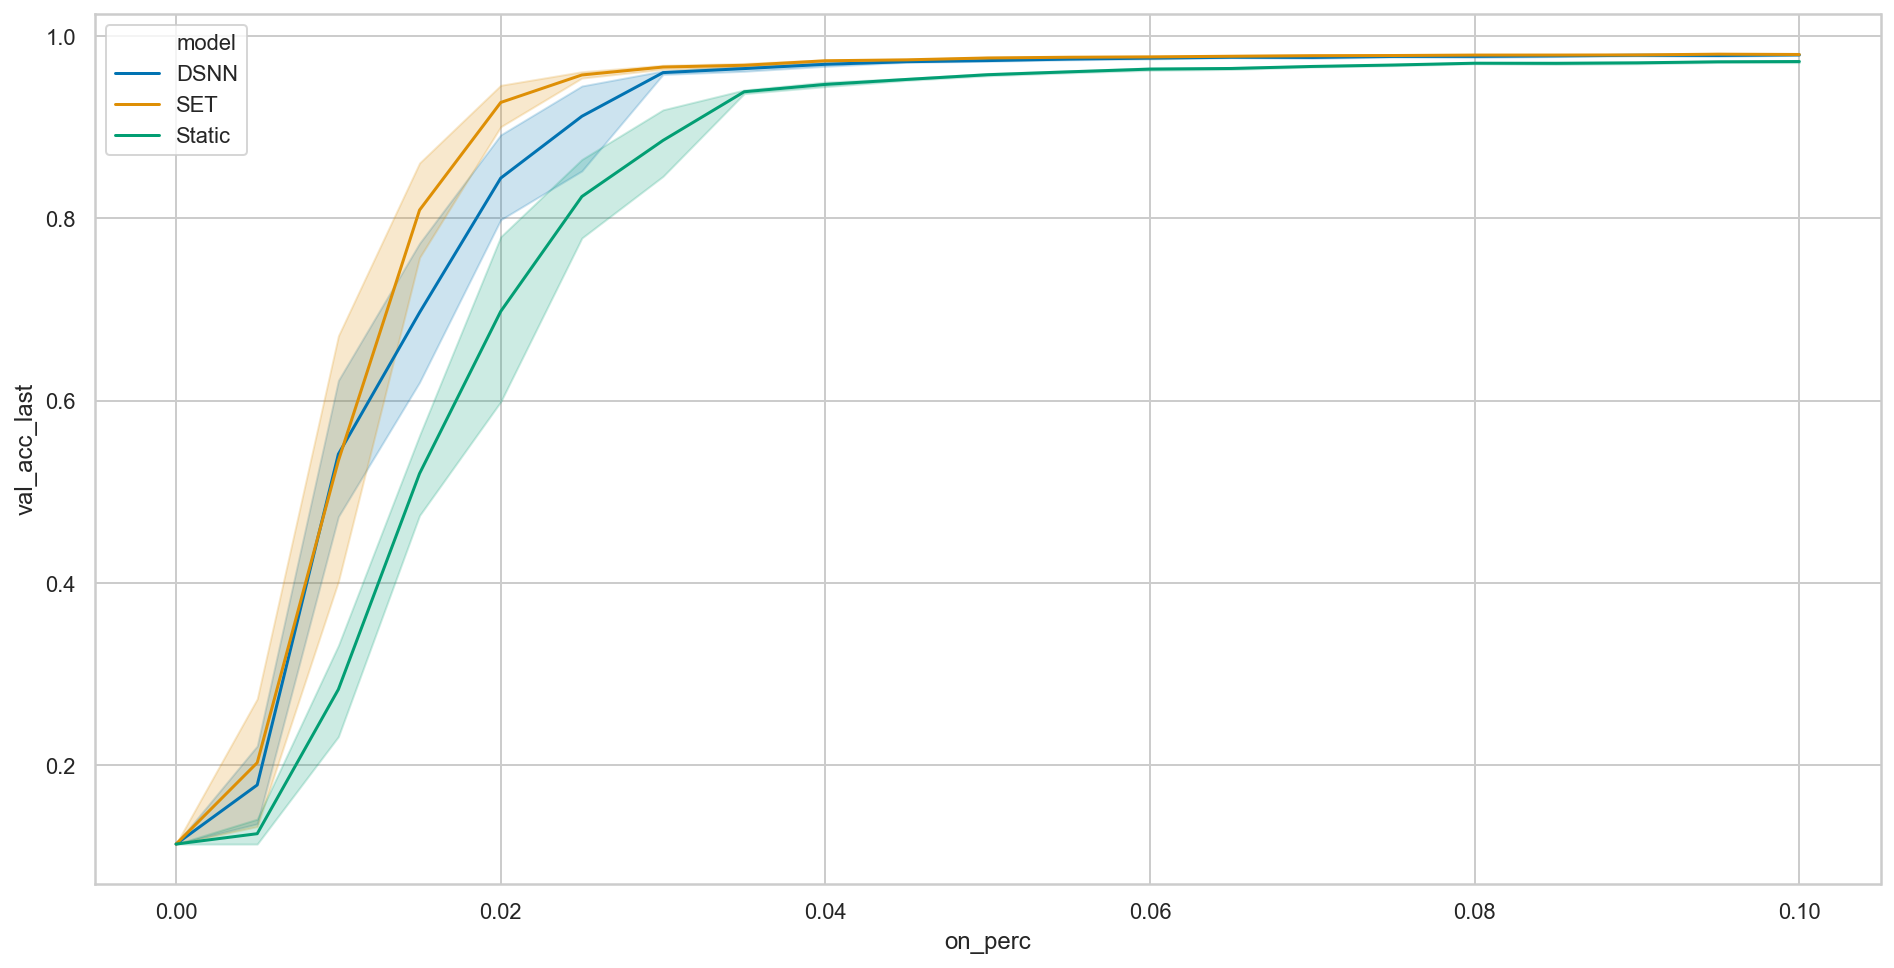

In [21]:
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_last', hue='model')